In [11]:
import numpy as np
import scipy as sc
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import itertools
%matplotlib inline

In [12]:
from os import listdir
from os.path import isfile, join
path = '../RetweetDataAOAS/retweet_data/'
root_tweet_names = [f for f in listdir(path) if isfile(join(path, f))]

In [13]:
# Produces a dictionary of dataframes for each tweetfile, with initial 
# preprocessing
fields = ['RetweetCount', 'UserId', 'ScreenName', 'FollowerCount', 
          'DistanceFromRoot','Time', 'ParentScreenName', 'Text']
tweet_dfs = {}
for i in range(len(root_tweet_names)):
    tweet_df = pd.read_csv(path+root_tweet_names[i], sep="\t", header=None, 
                         quoting=csv.QUOTE_NONE, names=fields, encoding = "ISO-8859-1")
    
    tweet_df['Time'] = pd.to_datetime(tweet_df['Time'])

    screen_name_index = {}
    for index, row in tweet_df.iterrows():
        screen_name_index[row['ScreenName']] = index
    tweet_df['ParentDfIndex'] = tweet_df['ParentScreenName'].map(screen_name_index)
    
    tweet_dfs[i] = tweet_df

In [14]:
# Returns a dictionary of reaction times S_j^x keyed by user id
def generate_reaction_times(tweet_df):
    reaction_times = {}
    for index, row in tweet_df.iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_df.at[row['ParentDfIndex'],
                                                      'Time']
            reaction_times[row['UserId']] = reaction_time
    return reaction_times

In [15]:
# Returns a dictionary of M_j^x keyed by user id
def generate_number_of_follower_who_retweet(tweet_df):
    number_of_follower_who_retweet = {}
    for index, row in tweet_df.iterrows():
        if row['UserId'] not in number_of_follower_who_retweet:
            number_of_follower_who_retweet[row['UserId']] = 0
        parent_user_id = tweet_df.at[row['ParentDfIndex'], 'UserId']
        number_of_follower_who_retweet[parent_user_id] += 1
    return number_of_follower_who_retweet

In [18]:
tweet_df_1 = tweet_dfs[1]
s_j_x = sorted(generate_reaction_times(tweet_df_1).values())
log_s_j_x = [np.log(i.seconds) for i in s_j_x]
tweet_df_1_users = list(tweet_df_1['UserId'])
m_j_x_dic = generate_number_of_follower_who_retweet(tweet_df_1)
m_j_x_lis = []
for key in m_j_x_dic.keys():
    m_j_x_lis.append(m_j_x_dic[key])

In [17]:
print(root_tweet_names)

['Source_followers_tweet_0037_EvaLongoria.txt', 'Source_followers_tweet_0074_iamwill.txt', 'Source_followers_tweet_0074_Tip.txt', 'Source_followers_tweet_0161_SuckerFreeMTV2.txt', 'Source_followers_tweet_0304_KimKardashian.txt', 'Source_followers_tweet_0101_Pitbull.txt', 'Source_followers_tweet_0048_MissInfoTV.txt', 'Source_followers_tweet_0108_newtgingrich.txt', 'Source_followers_tweet_0142_myfabolouslife.txt', 'Source_followers_tweet_0044_JonnyBones.txt', 'Source_followers_tweet_0101_myfabolouslife.txt', 'Source_followers_tweet_0092_AnnCoulter.txt', 'Source_followers_tweet_0031_CNET.txt', 'Source_followers_tweet_0022_Lawrence.txt', 'Source_followers_tweet_0107_djkhaled.txt', 'Source_followers_tweet_0127_newtgingrich.txt', 'Source_followers_tweet_0734_rickyrozay.txt', 'Source_followers_tweet_0176_AnnCoulter.txt', 'Source_followers_tweet_0070_E40.txt', 'Source_followers_tweet_0462_AnnDRomney.txt', 'Source_followers_tweet_0167_rickyrozay.txt', 'Source_followers_tweet_0611_BarackObama.tx

In [21]:
with pm.Model() as strawman_model:
    lamb = pm.Gamma('lambda', alpha=1, beta=1./500)
    m_preds = pm.Poisson('follower_count', mu=lamb, observed=m_j_x_lis, shape=len(m_j_x_lis))

In [22]:
# Run and fit our model
with strawman_model:
    trace = pm.sample(1000, tune=2000, cores=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_log__]
100%|██████████| 3000/3000 [00:01<00:00, 1743.92it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '2841' (I am process '2842')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/kelvinlu/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '2841' (I am process '2843')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/kelvinlu/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '2842' (I am process '2843')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/kelvinlu/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir


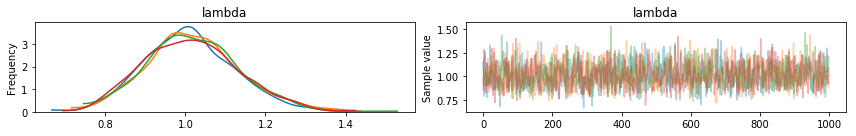

In [23]:
with strawman_model:
    pm.traceplot(trace);
